### Import packages & load data

In [1]:
import pandas as pd
import numpy as np
import pywt
from scipy.signal import iirnotch, filtfilt, butter
from scipy.ndimage import binary_closing, binary_opening
from scipy.stats import entropy, skew

eeg_data_1 = pd.read_csv('data/muselsl-sample-10min-3.csv')
gradcpt_data_1 = pd.read_csv('data/gradcpt-sample-10min-3.csv')
eeg_data_2 = pd.read_csv('data/muselsl-sample-10min-4.csv')
gradcpt_data_2 = pd.read_csv('data/gradcpt-sample-10min-4.csv')
eeg_data_3 = pd.read_csv('data/muselsl-sample-10min-5.csv')
gradcpt_data_3 = pd.read_csv('data/gradcpt-sample-10min-5.csv')

# eeg_data_4 = pd.read_csv('data/muselsl-sample-10min-1.csv')
# gradcpt_data_4 = pd.read_csv('data/gradcpt-sample-10min-1.csv')
# eeg_data_5 = pd.read_csv('data/muselsl-sample-10min-2.csv')
# gradcpt_data_5 = pd.read_csv('data/gradcpt-sample-10min-2.csv')


# Add a column to indicate the trial number
eeg_data_1['trial'] = 1
gradcpt_data_1['trial'] = 1
eeg_data_2['trial'] = 2
gradcpt_data_2['trial'] = 2
eeg_data_3['trial'] = 3
gradcpt_data_3['trial'] = 3

# eeg_data_4['trial'] = 4
# gradcpt_data_4['trial'] = 4
# eeg_data_5['trial'] = 5
# gradcpt_data_5['trial'] = 5

### Syncrhonize the start times of the EEG and GradCPT data

In [2]:
def synchronize_trials(eeg_df, gradcpt_df):
    start_diff = eeg_df['timestamps'][0] - gradcpt_df['start_timestamp'][0]

    if start_diff < 0:
        # If eeg_data starts earlier, align it to gradcpt_data
        closest_idx = (eeg_df['timestamps'] - gradcpt_df['start_timestamp'][0]).abs().idxmin()
        eeg_df_aligned = eeg_df[closest_idx-1:].reset_index(drop=True)
        gradcpt_df_aligned = gradcpt_df.copy()
    else:
        # If gradcpt_data starts earlier, find the point where eeg_data starts
        i = next(i for i, ts in enumerate(gradcpt_df['start_timestamp']) if ts > eeg_df['timestamps'][0])
        gradcpt_df_aligned = gradcpt_df[i:].reset_index(drop=True)
        closest_idx = (eeg_df['timestamps'] - gradcpt_df_aligned['start_timestamp'][0]).abs().idxmin()
        eeg_df_aligned = eeg_df[closest_idx-1:].reset_index(drop=True)

    return eeg_df_aligned, gradcpt_df_aligned


In [3]:
eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

# eeg_data_4, gradcpt_data_4 = synchronize_trials(eeg_data_4, gradcpt_data_4)
# eeg_data_5, gradcpt_data_5 = synchronize_trials(eeg_data_5, gradcpt_data_5)

# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, eeg_data_2, eeg_data_3, 
                     # eeg_data_4, 
                     # eeg_data_5
                     ], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, gradcpt_data_2, gradcpt_data_3, 
                          #gradcpt_data_4, 
                          #gradcpt_data_5
                         ], ignore_index=True)

In [4]:
# Remove other channels
channels = ['timestamps', 'AF8', 'trial']
af8 = eeg_data[channels].copy()

### z-normalization

In [5]:
mean = af8['AF8'].mean()
std = af8['AF8'].std()
af8.loc[:, 'AF8_normal'] = (af8['AF8'] - mean) / std

### Artifact removal

In [6]:
# get rid of the
# Remove the 50Hz power line artifact
fs = 256
f0 = 50
quality_factor = 30

b, a = iirnotch(f0, quality_factor, fs)
af8.loc[:, 'AF8_filt'] = filtfilt(b, a, af8['AF8_normal'])

# Remove EOG artifacts
threshold = 3
window_ms = 450 # Duration of the EOG event window in milliseconds (from zhang et al)
window_samples = int((window_ms / 1000) * fs) # Convert window duration from ms to number of samples

eog_peaks = np.where(np.abs(af8['AF8_filt']) > threshold)[0]
eog_regions = np.zeros_like(af8['AF8_filt'], dtype=bool)
for peak in eog_peaks:
    start = max(peak - window_samples // 2, 0)
    end = min(peak + window_samples // 2, len(af8['AF8_filt']))
    eog_regions[start:end] = True

structuring_element = np.ones(window_samples)
eog_regions_closed = binary_closing(eog_regions, structure=structuring_element)
eog_regions_cleaned = binary_opening(eog_regions_closed, structure=structuring_element)

af8.loc[:, 'AF8_artif_removed'] = af8['AF8_filt'].copy()
for start in np.where(np.diff(eog_regions_cleaned.astype(int)) == 1)[0] + 1:
    end = start + np.where(eog_regions_cleaned[start:] == False)[0][0]
    replacement_length = end - start
    replacement_start = max(start - replacement_length, 0)

    # Handle the case where the artifact is at the very start of the signal
    if start == 0:  # If the artifact is at the very start
        replacement_values = af8['AF8_filt'][end:end+replacement_length]  # Use following clean segment
    else:
        replacement_values = af8['AF8_artif_removed'][replacement_start:replacement_start+replacement_length]

    # Replace the artifact segment with the corresponding clean segment
    af8.loc[start:end - 1, 'AF8_artif_removed'] = replacement_values.values

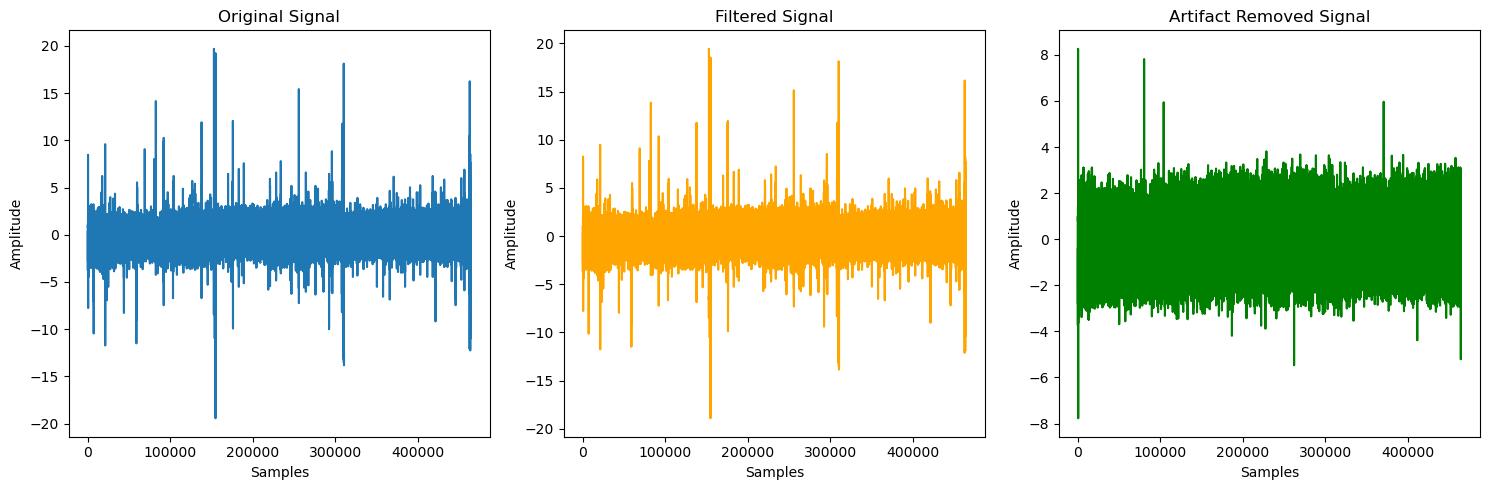

In [7]:
import matplotlib.pyplot as plt

# Plot the original, filtered, and artifact removed signals for comparison
plt.figure(figsize=(15, 5))

# Original signal
plt.subplot(1, 3, 1)
plt.plot(af8['AF8_normal'], label='Original')
plt.title('Original Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

# Filtered signal
plt.subplot(1, 3, 2)
plt.plot(af8['AF8_filt'], label='Filtered', color='orange')
plt.title('Filtered Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

# Artifact removed signal
plt.subplot(1, 3, 3)
plt.plot(af8['AF8_artif_removed'], label='Artifact Removed', color='green')
plt.title('Artifact Removed Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

### Bandpass filtering

In [8]:
# Parameters
lowcut = 0.5
highcut = 50.0
fs = 256  
filter_order = 5

# Butterworth filter
nyquist_freq = 0.5 * fs
low = lowcut / nyquist_freq
high = highcut / nyquist_freq
b, a = butter(filter_order, [low, high], btype="band")
af8.loc[:, ['AF8_bandpassed']] = filtfilt(b, a, af8['AF8_artif_removed'])

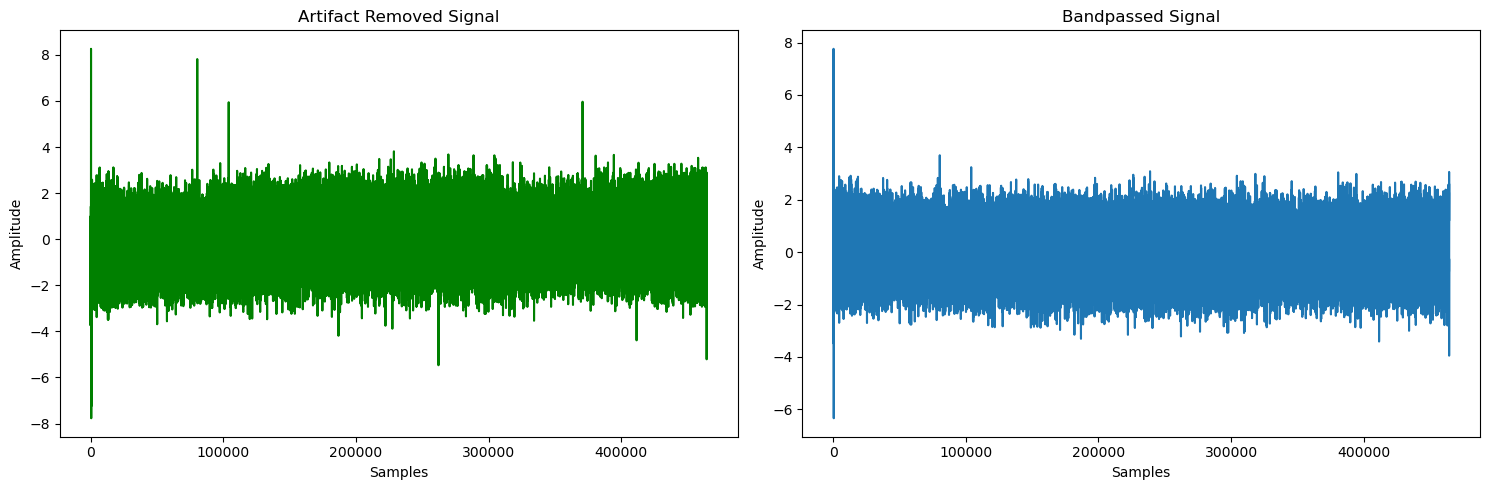

In [9]:
import matplotlib.pyplot as plt

# Plot the original, filtered, and artifact removed signals for comparison
plt.figure(figsize=(15, 5))

# Artifact removed signal
plt.subplot(1, 2, 1)
plt.plot(af8['AF8_artif_removed'], label='Artifact Removed', color='green')
plt.title('Artifact Removed Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

# Original signal
plt.subplot(1, 2, 2)
plt.plot(af8['AF8_bandpassed'], label='Bandpassed')
plt.title('Bandpassed Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

### Segmentation

In [10]:
# Separate preprocessed data back into individual trials
eeg_data_t1 = af8[af8['trial'] == 1].drop(columns=['trial'])
gradcpt_data_t1 = gradcpt_data[gradcpt_data['trial'] == 1].drop(columns=['trial'])

eeg_data_t2 = af8[af8['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t2 = gradcpt_data[gradcpt_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)

eeg_data_t3 = af8[af8['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t3 = gradcpt_data[gradcpt_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)

# eeg_data_t4 = af8[af8['trial'] == 4].drop(columns=['trial']).reset_index(drop=True)
# gradcpt_data_t4 = gradcpt_data[gradcpt_data['trial'] == 4].drop(columns=['trial']).reset_index(drop=True)

# eeg_data_t5 = af8[af8['trial'] == 5].drop(columns=['trial']).reset_index(drop=True)
# gradcpt_data_t5 = gradcpt_data[gradcpt_data['trial'] == 5].drop(columns=['trial']).reset_index(drop=True)

In [11]:
# 256*0.8=204.8 ||| 204*(1/256)=0,7969 and 205*(1/256)=0,8008
# 205 is closer to 800 and gradcpt usually takes a fraction of ms longer than 800ms
def segment(eeg_df, gradcpt_df):
    segment_samples = 205
    
    num_segments = len(gradcpt_df['in_the_zone'])
    segments = []
    timestamps = []
    for i in range(num_segments):
        start = i * segment_samples
        end = start + segment_samples
        segment = eeg_df['AF8_bandpassed'][start:end].values
        timestamps.append(eeg_df['timestamps'][start])
        segments.append(segment)

    return segments, timestamps

In [12]:
segments_t1, timestamps_t1 = segment(eeg_data_t1, gradcpt_data_t1)
segments_t2, timestamps_t2 = segment(eeg_data_t2, gradcpt_data_t2)
segments_t3, timestamps_t3 = segment(eeg_data_t3, gradcpt_data_t3)

# segments_t4, timestamps_t4 = segment(eeg_data_t4, gradcpt_data_t4)
# segments_t5, timestamps_t5 = segment(eeg_data_t5, gradcpt_data_t5)

### Discrete Wavelet Transform

In [13]:
# try IIR filter instead
def decompose_segment(segment, wavelet='sym3', max_level=5):
    if max_level is None:
        max_level = pywt.dwt_max_level(len(segment), wavelet)
    
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(segment, wavelet, level=max_level)

    bands = {'delta': None, 'theta': None, 'alpha': None, 'beta': None, 'gamma': None}

    # Start from gamma to match Zhang et al.
    bands['gamma'] = pywt.upcoef('d', coeffs[1], wavelet, level=max_level, take=len(segment))

    for i in range(2, max_level + 1):
        if i == max_level:
            # Extract delta band from the last level approximation coefficients
            bands['delta'] = pywt.upcoef('a', coeffs[-1], wavelet, level=1, take=len(segment))
        else:
            # Extract other bands by reconstructing from specific detail coefficients
            band_name = {2: 'beta', 3: 'alpha', 4: 'theta'}[i]
            bands[band_name] = pywt.upcoef('d', coeffs[i], wavelet, level=max_level-i+1, take=len(segment))

    return bands
    

In [14]:
segment_bands_t1 = [decompose_segment(segment) for segment in segments_t1]
segment_bands_t2 = [decompose_segment(segment) for segment in segments_t2]
segment_bands_t3 = [decompose_segment(segment) for segment in segments_t3]

# segment_bands_t4 = [decompose_segment(segment) for segment in segments_t4]
# segment_bands_t5 = [decompose_segment(segment) for segment in segments_t5]

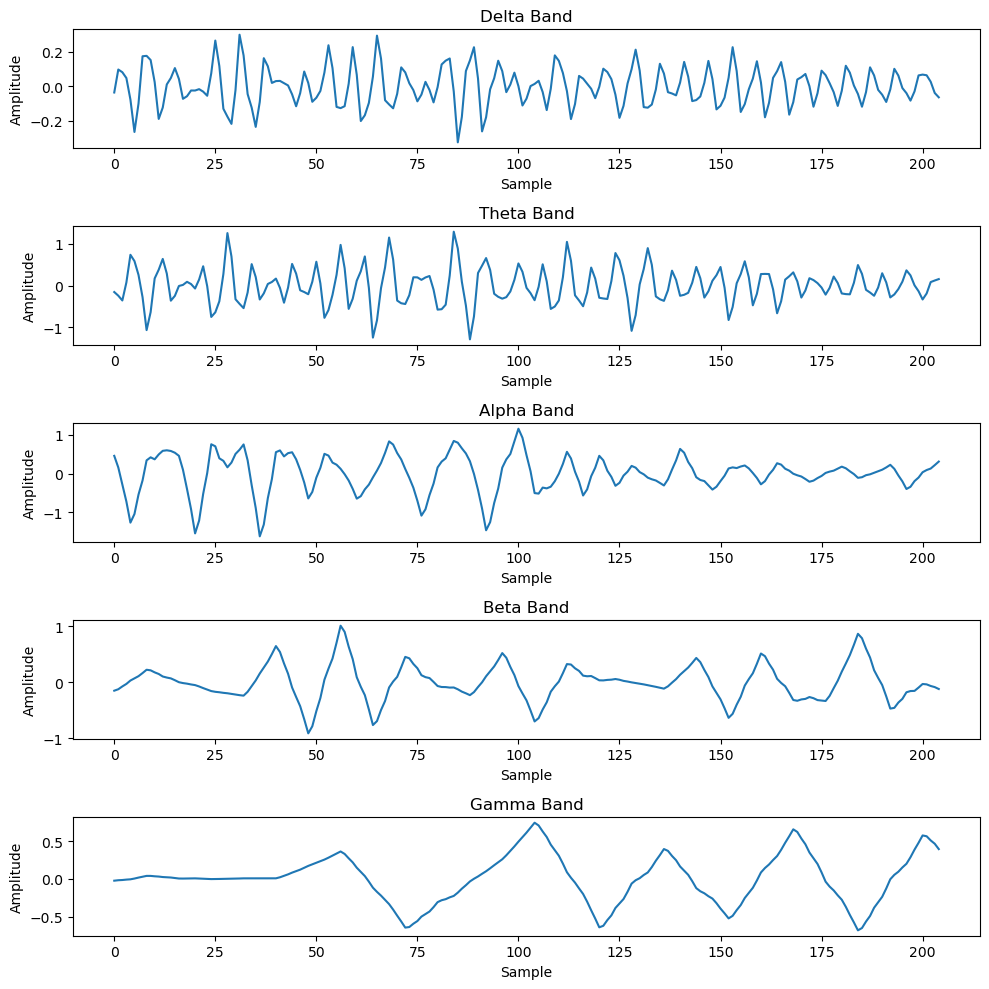

In [15]:
import matplotlib.pyplot as plt

first_segment_bands = segment_bands_t1[0]  # Get the bands for the first segment

num_bands = len(first_segment_bands)
fig, axes = plt.subplots(num_bands, 1, figsize=(10, 2 * num_bands))

# Plot each band in a separate subplot
for i, (band_name, band_signal) in enumerate(first_segment_bands.items()):
    ax = axes[i] if num_bands > 1 else axes  # Handle the case of a single subplot
    ax.plot(band_signal)
    ax.set_title(f"{band_name.capitalize()} Band")
    ax.set_xlabel("Sample")
    ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


### Feature Computation

In [16]:
def approximate_entropy(signal, m=2, r=None):
    def _maxdist(x_i, x_j):
        return np.max(np.abs(x_i - x_j), axis=1)

    def _phi(m, x, N, r):
        C = np.zeros(len(x))
        for i, x_i in enumerate(x):
            # Calculate distance in a vectorized manner
            dists = _maxdist(x_i, x)
            # Count the number of distances less than or equal to r
            C[i] = np.sum(dists <= r) / (N - m + 1.0)
        C += 1e-10  # To avoid log(0)
        
        return np.sum(np.log(C)) / (N - m + 1.0)

    # Ensure 'signal' is a numpy array
    U = np.array(signal)
    N = len(U)

    # Set the similarity criterion 'r' if it is not provided
    if r is None:
        r = 0.2 * np.std(signal)
        
    # Precompute slices of U for different values of m
    x_m = [np.array([U[j:j+m] for j in range(N - m + 1)]) for m in [m, m+1]]
    
    # Calculate approximate entropy using precomputed slices
    return abs(_phi(m + 1, x_m[1], N, r) - _phi(m, x_m[0], N, r))


def total_variation(signal):
    return np.sum(np.abs(np.diff(signal)))

def standard_deviation(signal):
    return np.std(signal)

def energy(signal):
    return np.sum(np.square(signal))

def skewness(signal):
    return skew(signal)

In [17]:
def extract_features(segments, gradcpt_df):
    # Define bands and features for clarity and extensibility
    bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    
    # Calculate features for each segment and store them
    features_data = []
    for i in range(len(segments)):
        segment_features = {}
        for band in bands:
            segment_features[f'{band}_approx_entropy'] = approximate_entropy(segments[i][band])
            segment_features[f'{band}_total_variation'] = total_variation(segments[i][band])
            segment_features[f'{band}_standard_deviation'] = standard_deviation(segments[i][band])
            segment_features[f'{band}_energy'] = energy(segments[i][band])
            segment_features[f'{band}_skewness'] = skewness(segments[i][band])
    
        features_data.append(segment_features)
    
    # Now, for each segment, append features from preceding 9 windows
    augmented_features_data = []
    
    for i in range(len(features_data)):
        augmented_features = {}
        for j in range(max(0, i-9), i+1):
            for key, value in features_data[j].items():
                # Adjust the key to include the window index relative to the current segment
                augmented_key = f'{key}_win{j-i}'
                augmented_features[augmented_key] = value
                
        augmented_features_data.append(augmented_features)
    
    # Create a DataFrame from the augmented features data
    features_df = pd.DataFrame(augmented_features_data)
    features_df['in_the_zone'] = gradcpt_df['in_the_zone']
    features_df.fillna(0, inplace=True)

    return features_df

In [18]:
features_t1 = extract_features(segment_bands_t1, gradcpt_data_t1)
features_t2 = extract_features(segment_bands_t2, gradcpt_data_t2)
features_t3 = extract_features(segment_bands_t3, gradcpt_data_t3)

# features_t4 = extract_features(segment_bands_t4, gradcpt_data_t4)
# features_t5 = extract_features(segment_bands_t5, gradcpt_data_t5)

In [19]:
combined_features_df = pd.concat([features_t2, features_t3], ignore_index=True)

### Find 25 most and least important features

In [20]:
from scipy.stats import ttest_ind
t_values = []
feature_names = []

# Perform t-test for each feature against 'in_the_zone'
for column in combined_features_df.columns[:-1]:  # Exclude the last column ('in_the_zone')
    t_stat, p_val = ttest_ind(combined_features_df[column], combined_features_df['in_the_zone'], nan_policy='omit')
    t_values.append(t_stat)
    feature_names.append(column)

# Create a DataFrame to store features and their corresponding t-values
t_values_df = pd.DataFrame({'Feature': feature_names, 'T-value': t_values})

# Sort the DataFrame by the absolute t-values
t_values_df['Abs T-value'] = t_values_df['T-value'].abs()
t_values_df_sorted = t_values_df.sort_values(by='Abs T-value', ascending=False)

# Select the 25 most important features
top_25_features = t_values_df_sorted.head(25);

# Select the 25 least important features
bottom_25_features = t_values_df_sorted.tail(25);

# You can now print or further analyze these subsets
print("Top 25 Most Important Features:")
print(top_25_features)

print("\nBottom 25 Least Important Features:")
print(bottom_25_features)

Top 25 Most Important Features:
                         Feature     T-value  Abs T-value
11    alpha_total_variation_win0  228.805562   228.805562
6     theta_total_variation_win0  228.125898   228.125898
36   alpha_total_variation_win-1  223.162017   223.162017
31   theta_total_variation_win-1  223.061075   223.061075
1     delta_total_variation_win0  219.647398   219.647398
56   theta_total_variation_win-2  218.076788   218.076788
61   alpha_total_variation_win-2  217.892396   217.892396
26   delta_total_variation_win-1  214.515661   214.515661
81   theta_total_variation_win-3  213.493005   213.493005
86   alpha_total_variation_win-3  213.323628   213.323628
51   delta_total_variation_win-2  209.638658   209.638658
106  theta_total_variation_win-4  209.048091   209.048091
111  alpha_total_variation_win-4  208.858237   208.858237
76   delta_total_variation_win-3  205.127081   205.127081
136  alpha_total_variation_win-5  204.721152   204.721152
131  theta_total_variation_win-5  204.69

## Training

In [21]:
for _ in range(7):
    from scipy.stats import ttest_ind
    from sklearn.model_selection import StratifiedKFold, GridSearchCV
    from sklearn.metrics import balanced_accuracy_score
    from sklearn.svm import SVC
    
    features = combined_features_df.iloc[:, :-1].values
    labels = combined_features_df.iloc[:, -1].values
    
    def select_top_features(X, y, num_features=10):
        # Perform a t-test across features
        t_stats, p_values = ttest_ind(X[y == 0], X[y == 1], axis=0)
        # Select indices of top features based on smallest p-values
        top_features_indices = np.argsort(p_values)[:num_features]
        return top_features_indices
    
    outer_cv = StratifiedKFold(n_splits=10, shuffle=True)
    
    balanced_acc_scores = []
    
    for train_index, test_index in outer_cv.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
    
        # Feature selection for the outer fold
        top_features_indices = select_top_features(X_train, y_train)
        X_train_selected = X_train[:, top_features_indices]
        X_test_selected = X_test[:, top_features_indices]
    
        # Inner CV for hyperparameter truning
        inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']}
        grid_search = GridSearchCV(SVC(), param_grid, cv=inner_cv, scoring='balanced_accuracy')
        grid_search.fit(X_train_selected, y_train)
    
        best_model = grid_search.best_estimator_
        
    
        balanced_acc = balanced_accuracy_score(y_test, best_model.predict(X_test_selected))
        balanced_acc_scores.append(balanced_acc)
    
    final_performance = np.mean(balanced_acc_scores)
    print(f'Final model balanced accuracy: {final_performance}')

Final model balanced accuracy: 0.5972868073553006
Final model balanced accuracy: 0.59556929532272
Final model balanced accuracy: 0.6014689621127978
Final model balanced accuracy: 0.5914453905960755
Final model balanced accuracy: 0.6019614957423177
Final model balanced accuracy: 0.5933060594841416
Final model balanced accuracy: 0.5917998272244848


In [66]:
# df_t1 = combined_features_df[:len(combined_features_df)//3].reset_index(drop=True)
# df_t2 = combined_features_df[len(combined_features_df)//3:len(combined_features_df)//3*2].reset_index(drop=True)
# df_t3 = combined_features_df[len(combined_features_df)//3*2:len(combined_features_df)//3*3].reset_index(drop=True)

# print(df_t1.shape, df_t2.shape, df_t3.shape)

- delta from 1
- gamma from 40
- skip normalization 
- IIR filter instead of DWT
### Multichannel
- normalize every channel separately

In [67]:
np.mean([59.5, 59.9, 60.5, 59.4, 58.9, 59.6, 59.7, 59.8])

59.6625